<a href="https://colab.research.google.com/github/DimasAdhie12/Visi-Komputer/blob/main/Jobsheet%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Praktikum D1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)
    cv2.circle(img, (cx, cy), r, (255,), -1)
    img = (img / 255.0).astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

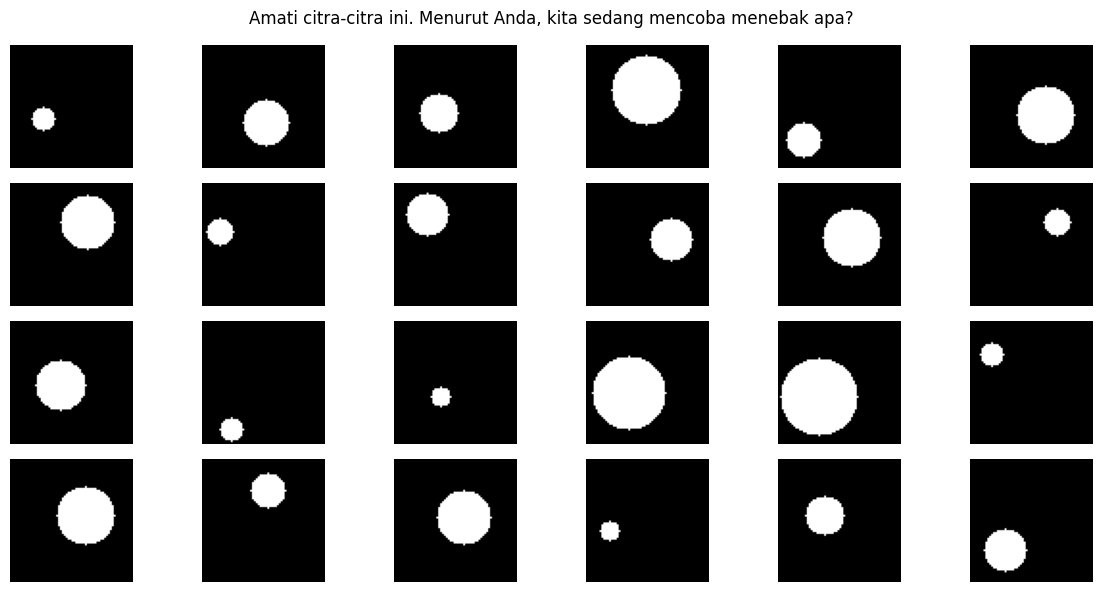

In [2]:
# Contoh visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]

cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

In [3]:
# Dataset untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=12, batch_size=64, verbose=0)

KeyboardInterrupt: 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
MAE=0.928 | RMSE=1.146 | R²=0.939


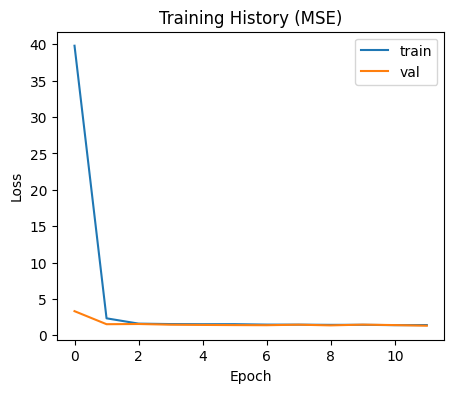

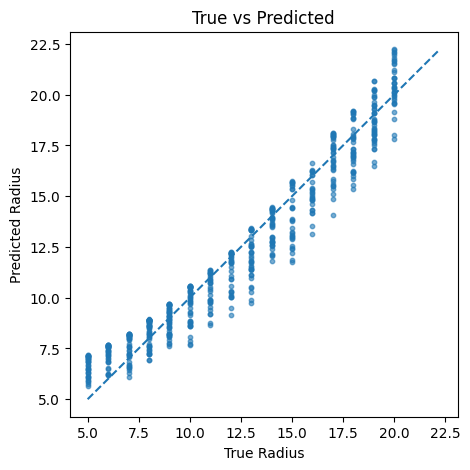

In [ ]:
# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("True vs Predicted")
plt.show()

###Praktikum D2

In [ ]:
# Jalankan ini di awal notebook
from google.colab import files
files.upload() # pilih file kaggle.json dari komputer Anda

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dimasadhienugroho","key":"264c7c82b4f364ac5b3e5e378d42b81c"}'}

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


In [ ]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


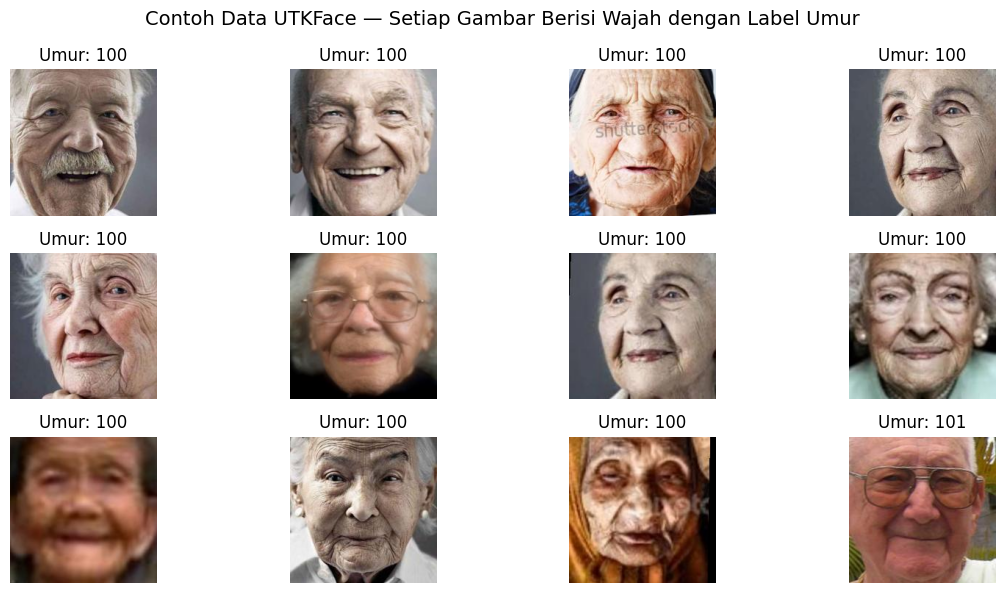

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image
# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Fungsi untuk mengambil umur dari nama file
def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

# Membuat array umur dari daftar file gambar
ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

# Membagi dataset menjadi train dan test
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

# Ukuran gambar yang digunakan
IMG_SIZE = 160

# Fungsi untuk memuat dan memproses gambar
def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # normalisasi ke [0,1]
    return img, label

# Membuat TensorFlow Dataset untuk training dan testing
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_files, y_train))
    .map(load_img)
    .batch(64)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_files, y_test))
    .map(load_img)
    .batch(64)
)

print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = False  # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur

model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

model.summary()

Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 57s 132ms/step - loss: 336.9020 - mae: 13.4933 - val_loss: 156.9867 - val_mae: 9.5263 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 152.9277 - mae: 9.1969 - val_loss: 145.8038 - val_mae: 9.0829 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 143.3373 - mae: 8.7868 - val_loss: 138.5922 - val_mae: 8.7404 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 135.9844 - mae: 8.5881 - val_loss: 135.2139 - val_mae: 8.6029 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 135.8749 - mae: 8.5713 - val_loss: 134.0847 - val_mae: 8.5739 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 132.7339 - mae: 8.4048 - val_loss: 135.1839 - val_mae: 8.6647 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 129.2633 - mae: 8.3216 - val_loss: 132.9821 - va

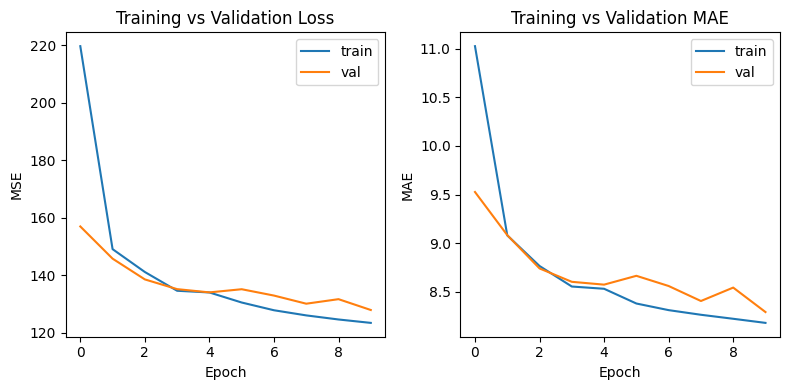

In [ ]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.5,
        min_lr=1e-5,
        monitor='val_loss'
    )
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 49s 103ms/step - loss: 200.3854 - mae: 10.4284 - val_loss: 149.6060 - val_mae: 9.2575 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 79.1396 - mae: 6.6334 - val_loss: 131.9592 - val_mae: 8.8601 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 52.4178 - mae: 5.4614 - val_loss: 110.3183 - val_mae: 7.6304 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 38.2183 - mae: 4.7062 - val_loss: 102.1321 - val_mae: 7.3746 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 29.9726 - mae: 4.1838 - val_loss: 97.2539 - val_mae: 7.1914 - learning_rate: 1.0000e-04


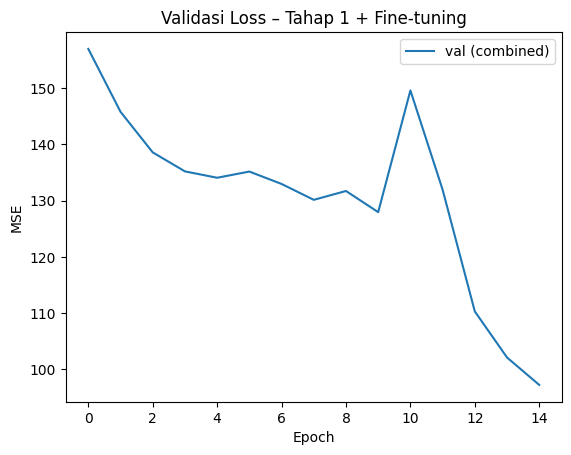

In [ ]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False  # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning
plt.plot(
    history.history['val_loss'] + history_ft.history['val_loss'],
    label='val (combined)'
)
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

MAE = 7.19 tahun
RMSE = 9.86 tahun
R² = 0.755


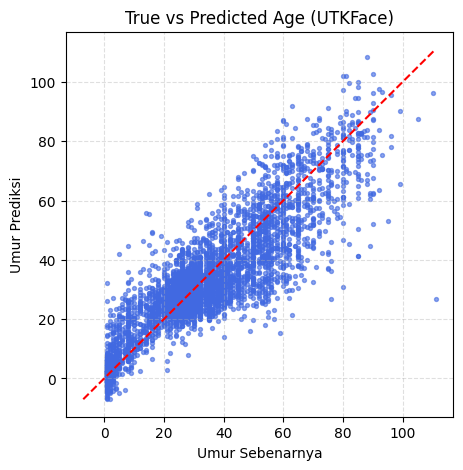

In [ ]:
from math import sqrt

y_pred = np.concatenate([
    model.predict(batch[0], verbose=0).ravel()
    for batch in test_ds
])

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred) ** 2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R² = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')

lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')

plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

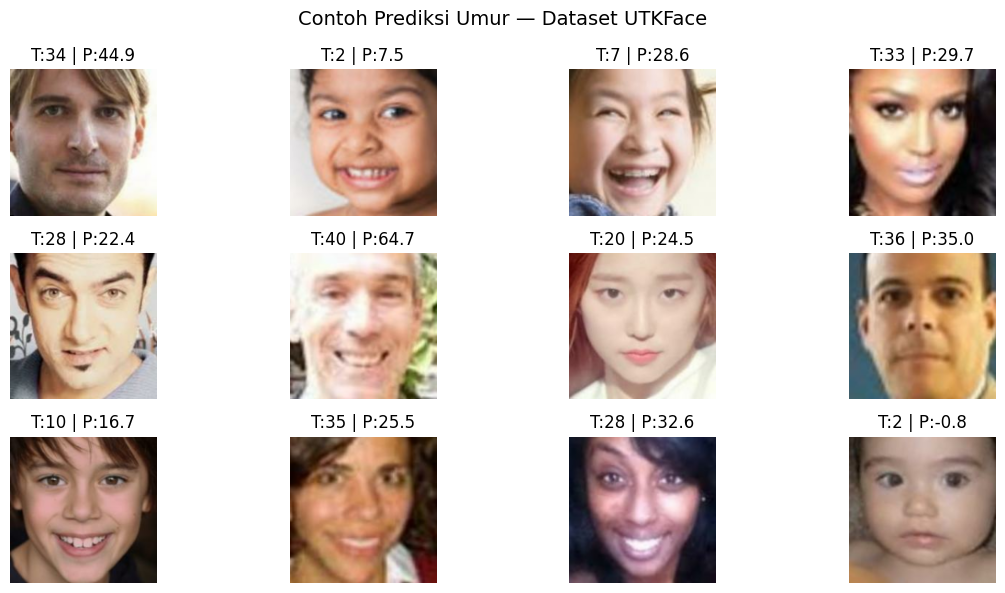

In [ ]:
import random

sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12, 6))

for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

###Praktikum D3

In [ ]:
from google.colab import files

# Upload file kaggle.json dari komputer
files.upload()  # pilih kaggle.json dari komputer Anda

import os, shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle.json to kaggle (1).json
✅ Kaggle API siap digunakan.


In [ ]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

✅ Dataset Pawpularity berhasil diekstrak.


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

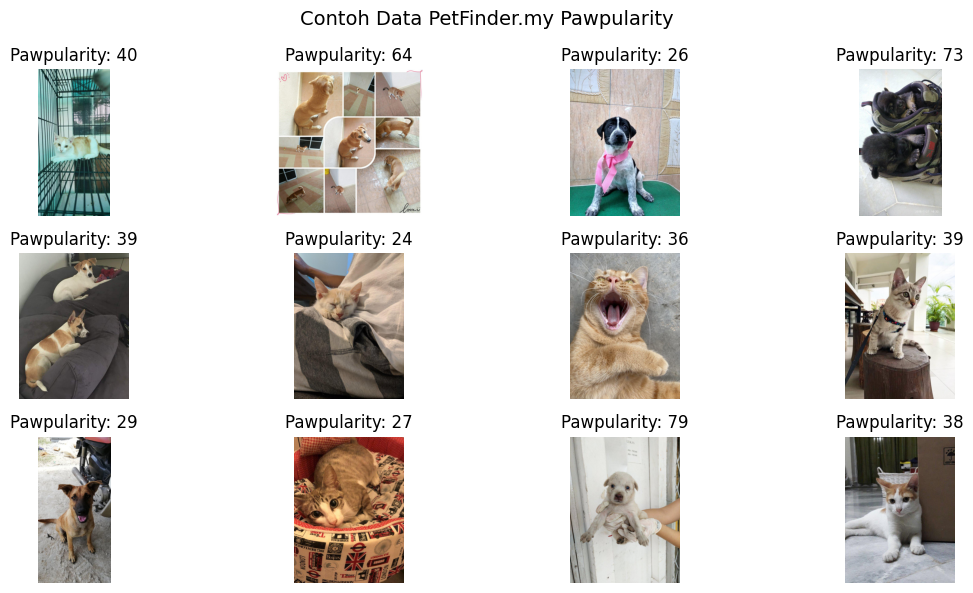

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))

for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224

# Bagi dataset menjadi train dan validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Fungsi untuk memuat dan memproses gambar
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

# Dataset untuk training
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(4096)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

# Dataset untuk validasi
val_ds = (
    tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


In [ ]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base.trainable = False  # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)

x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 106s 510ms/step - loss: 827.5518 - mae: 21.5489 - val_loss: 476.3891 - val_mae: 15.9559 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - loss: 421.9816 - mae: 15.1824 - val_loss: 432.3831 - val_mae: 15.5361 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 234ms/step - loss: 379.0924 - mae: 14.5212 - val_loss: 407.0432 - val_mae: 14.9552 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 200ms/step - loss: 380.6608 - mae: 14.4586 - val_loss: 389.7042 - val_mae: 14.4752 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - loss: 358.7695 - mae: 14.0789 - val_loss: 380.7353 - val_mae: 14.2048 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - loss: 345.2800 - mae: 13.8459 - val_loss: 375.1814 - val_mae: 14.3181 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 206ms/step - loss: 342.7202 - mae: 13.7269 - val_

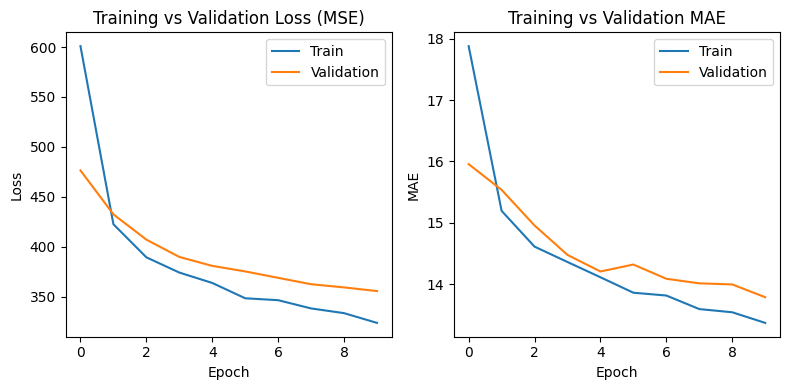

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

# Plot Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Training vs Validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()

MAE = 13.79
RMSE = 18.85
R² = 0.196


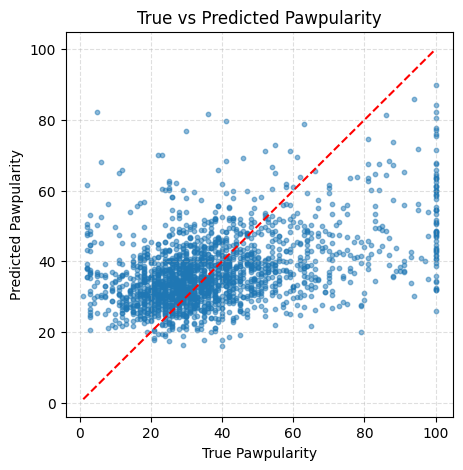

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([
    model.predict(batch[0], verbose=0).ravel()
    for batch in val_ds
])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred) ** 2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R² = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)

lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')

plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

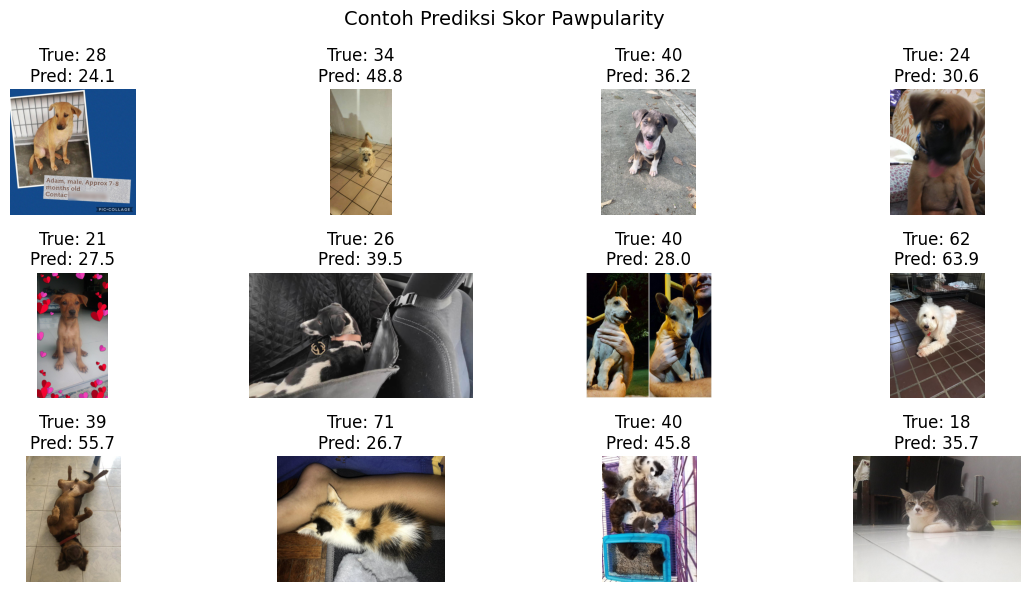

In [ ]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)
plt.figure(figsize=(12, 6))

for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(
        tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0),
        verbose=0
    ).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

###Tantangan Mini

###Tantangan 1

In [ ]:
# Tantangan 1: Tambahkan data augmentation agar model tidak bosan dengan pola yang sama
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, r2_score

# Pastikan variabel val_df, val_ds, train_df, load_image, IMG_SIZE sudah ada dari D3 utama
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE + 20, IMG_SIZE + 20)
    img = tf.image.random_crop(img, size=[IMG_SIZE, IMG_SIZE, 3])
    return img, label

train_aug = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

# Gunakan model EfficientNetB0 seperti sebelumnya
base_aug = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), weights='imagenet')
base_aug.trainable = False

inputs = tf.keras.Input((IMG_SIZE,IMG_SIZE,3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_aug(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_aug = tf.keras.Model(inputs, outputs)
model_aug.compile(optimizer='adam', loss='mse', metrics=['mae'])

cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history_aug = model_aug.fit(train_aug, validation_data=val_ds, epochs=10, callbacks=cb, verbose=1)

# Evaluasi
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model_aug.predict(batch[0], verbose=0).ravel() for batch in val_ds])
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)
print(f"(Augmented) MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 93s 451ms/step - loss: 815.6989 - mae: 21.7140 - val_loss: 484.5483 - val_mae: 16.3145 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 49s 262ms/step - loss: 424.8621 - mae: 15.2734 - val_loss: 436.9205 - val_mae: 15.4447 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 225ms/step - loss: 402.9196 - mae: 14.9439 - val_loss: 415.8557 - val_mae: 14.8520 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - loss: 391.5761 - mae: 14.6956 - val_loss: 393.8301 - val_mae: 14.4701 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - loss: 371.5823 - mae: 14.3087 - val_loss: 384.3774 - val_mae: 14.4045 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 262ms/step - loss: 358.2589 - mae: 14.2088 - val_loss: 376.5795 - val_mae: 14.1227 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 76s 222ms/step - loss: 346.4206 - mae: 13.7416 - val_l

###Tantangan 2

In [ ]:
# Tantangan 2: Ganti model dengan EfficientNetB3 / ResNet50
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score

# Gunakan model lebih besar: EfficientNetB3
base_b3 = tf.keras.applications.EfficientNetB3(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_b3.trainable = False

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_b3(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_b3 = tf.keras.Model(inputs, outputs)
model_b3.compile(optimizer='adam', loss='mse', metrics=['mae'])

cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history_b3 = model_b3.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=cb, verbose=1)

# Evaluasi performa model
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred_b3 = np.concatenate([model_b3.predict(batch[0], verbose=0).ravel() for batch in val_ds])
mae = mean_absolute_error(y_true, y_pred_b3)
rmse = np.sqrt(np.mean((y_true - y_pred_b3)**2))
r2 = r2_score(y_true, y_pred_b3)
print(f"(EfficientNetB3) MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 152s 754ms/step - loss: 890.4705 - mae: 22.5930 - val_loss: 494.0378 - val_mae: 16.2887 - learning_rate: 0.0010
Epoch 2/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 48s 279ms/step - loss: 422.9856 - mae: 15.1831 - val_loss: 429.0749 - val_mae: 15.4832 - learning_rate: 0.0010
Epoch 3/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 49s 286ms/step - loss: 398.5905 - mae: 14.9709 - val_loss: 394.4212 - val_mae: 14.6726 - learning_rate: 0.0010
Epoch 4/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 50s 265ms/step - loss: 373.1735 - mae: 14.4936 - val_loss: 383.1912 - val_mae: 14.4960 - learning_rate: 0.0010
Epoch 5/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 54s 296ms/step - loss: 360.7885 - mae: 14.2594 - val_loss: 375.3365 - val_mae: 14.2882 - learning_rate: 0.0010
Epoch 6/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 55s 307ms/step - loss: 342.4521 - mae: 13.8466 - val_loss: 371.3066 - val_mae: 14.3411 - learning_rate: 0.0010
Epoch 7/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 57s 318ms

###Tantangan 3

In [ ]:
# Tantangan Mini 3 Buat eksperimen kecil: pisahkan anjing vs kucing — apakah model bias ke salah satu spesies?

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle

# Gunakan model terbaik yang sudah dilatih
model_to_use = (
    model_b3 if 'model_b3' in globals()
    else model_aug if 'model_aug' in globals()
    else model
)

# Bagi subset validasi menjadi dua kelompok simulasi
val_paths = np.array(val_df['path'])
val_paths = shuffle(val_paths, random_state=42)
half = len(val_paths) // 2
dog_files = val_paths[:half]
cat_files = val_paths[half:]

def load_predict_list(paths, model):
    imgs = []
    for p in paths:
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.cast(img, tf.float32) / 255.0
        imgs.append(img)
    imgs = tf.stack(imgs)
    preds = model.predict(imgs, verbose=0).ravel()
    return preds

# Prediksi dua kelompok simulasi
dog_preds = load_predict_list(dog_files[:200], model_to_use)
cat_preds = load_predict_list(cat_files[:200], model_to_use)

# Analisis rata-rata skor prediksi
dog_mean = np.mean(dog_preds)
cat_mean = np.mean(cat_preds)

print("Analisis Rata-rata Skor:")
print(f"Kelompok 1 ('Dog' simulasi) rata-rata prediksi = {dog_mean:.2f}")
print(f"Kelompok 2 ('Cat' simulasi) rata-rata prediksi = {cat_mean:.2f}")

if dog_mean > cat_mean:
    print("=> Model memberi skor lebih tinggi ke kelompok 1 (anjing simulasi).")
elif cat_mean > dog_mean:
    print("=> Model memberi skor lebih tinggi ke kelompok 2 (kucing simulasi).")
else:
    print("=> Model seimbang antara kedua kelompok.")

# Analisis akurasi (MAE per kelompok)
val_df['species'] = np.random.choice(['dog', 'cat'], size=len(val_df))
y_pred = np.concatenate([
    model_to_use.predict(batch[0], verbose=0).ravel() for batch in val_ds
])
val_df['predicted_pawpularity'] = y_pred

dogs_df = val_df[val_df['species'] == 'dog']
cats_df = val_df[val_df['species'] == 'cat']

if not dogs_df.empty and not cats_df.empty:
    mae_dogs = mean_absolute_error(dogs_df['Pawpularity'], dogs_df['predicted_pawpularity'])
    mae_cats = mean_absolute_error(cats_df['Pawpularity'], cats_df['predicted_pawpularity'])

    print("\nAnalisis Akurasi (MAE per kelompok):")
    print(f"MAE untuk Anjing: {mae_dogs:.3f}")
    print(f"MAE untuk Kucing: {mae_cats:.3f}")

    if abs(mae_dogs - mae_cats) > 1.0:
        print("Model menunjukkan potensi bias performa.")
        if mae_dogs < mae_cats:
            print("=> Model lebih akurat untuk foto anjing.")
        else:
            print("=> Model lebih akurat untuk foto kucing.")
    else:
        print("=> Performa model relatif seimbang antara anjing dan kucing.")
else:
    print("=> Tidak cukup data untuk membandingkan performa anjing vs kucing.")

Analisis Rata-rata Skor:
Kelompok 1 ('Dog' simulasi) rata-rata prediksi = 37.50
Kelompok 2 ('Cat' simulasi) rata-rata prediksi = 36.56
=> Model memberi skor lebih tinggi ke kelompok 1 (anjing simulasi).

Analisis Akurasi (MAE per kelompok):
MAE untuk Anjing: 13.850
MAE untuk Kucing: 13.773
=> Performa model relatif seimbang antara anjing dan kucing.


###Tantangan 4

In [ ]:
# Tantangan 4: Gabungkan fitur non-visual (brightness) dengan hasil CNN
import cv2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Hitung tingkat kecerahan (brightness rata-rata) untuk setiap gambar
def calc_brightness(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

brightness_vals = np.array([calc_brightness(p) for p in val_df['path']])

# Prediksi dari model CNN (gunakan model terakhir yang dilatih)
cnn_preds = np.concatenate([model_to_use.predict(batch[0], verbose=0).ravel() for batch in val_ds])
true_vals = val_df['Pawpularity'].values

# Gabungkan hasil CNN dan brightness dalam model regresi linear
X = np.column_stack([cnn_preds, brightness_vals])
reg = LinearRegression().fit(X, true_vals)
pred_final = reg.predict(X)

# Evaluasi hasil kombinasi
mae = mean_absolute_error(true_vals, pred_final)
rmse = np.sqrt(np.mean((true_vals - pred_final)**2))
r2 = r2_score(true_vals, pred_final)

print(f"(CNN + Brightness) MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")

(CNN + Brightness) MAE=13.89 | RMSE=18.81 | R²=0.200


###Penugasan